In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from sklearn.decomposition import PCA

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
data = pd.read_csv("/data/predictive_maintenance.csv")

In [ ]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
y_binary =torch.tensor(data["Target"].values, dtype=torch.float32)


In [ ]:
y_binary

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
data = data.drop(["UDI", "Product ID", "Type", "Tool wear [min]", "Target", "Failure Type"], axis = 1)

In [ ]:
data

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm]
0,298.1,308.6,1551,42.8
1,298.2,308.7,1408,46.3
2,298.1,308.5,1498,49.4
3,298.2,308.6,1433,39.5
4,298.2,308.7,1408,40.0
...,...,...,...,...
9995,298.8,308.4,1604,29.5
9996,298.9,308.4,1632,31.8
9997,299.0,308.6,1645,33.4
9998,299.0,308.7,1408,48.5


In [ ]:
data_norm = (data-data.min())/(data.max() - data.min())

In [ ]:
data_norm

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm]
0,0.304348,0.358025,0.222934,0.535714
1,0.315217,0.370370,0.139697,0.583791
2,0.304348,0.345679,0.192084,0.626374
3,0.315217,0.358025,0.154249,0.490385
4,0.315217,0.370370,0.139697,0.497253
...,...,...,...,...
9995,0.380435,0.333333,0.253783,0.353022
9996,0.391304,0.333333,0.270081,0.384615
9997,0.402174,0.358025,0.277648,0.406593
9998,0.402174,0.370370,0.139697,0.614011


In [ ]:
# creating tensor from targets_df
X = torch.tensor(data_norm.values, dtype=torch.float32)

In [ ]:
X

tensor([[0.3043, 0.3580, 0.2229, 0.5357],
        [0.3152, 0.3704, 0.1397, 0.5838],
        [0.3043, 0.3457, 0.1921, 0.6264],
        ...,
        [0.4022, 0.3580, 0.2776, 0.4066],
        [0.4022, 0.3704, 0.1397, 0.6140],
        [0.4022, 0.3704, 0.1932, 0.5000]])

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y_binary[:train_split]
X_test, y_test = X[train_split:], y_binary[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(8000, 8000, 2000, 2000)

In [ ]:
# 1. Construct a model class that subclasses nn.Module
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=4, out_features=3)
        # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=3, out_features=2) # takes in 5 features, produces 1 feature (y)
        self.layer_3 = nn.Linear(in_features=2, out_features=1)
        self.relu = nn.ReLU()
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        return x # computation goes through layer_1 first then the output of layer_1 goes through layer_2




In [ ]:
# 4. Create an instance of the model and send it to target device
model_b = BinaryClassifier()
model_b

BinaryClassifier(
  (layer_1): Linear(in_features=4, out_features=3, bias=True)
  (layer_2): Linear(in_features=3, out_features=2, bias=True)
  (layer_3): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
def focal_loss(bce_loss, targets, alpha = 0.02, gamma = 9.37):
    """Binary focal loss, mean.

    Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
    improvements for alpha.
    :param bce_loss: Binary Cross Entropy loss, a torch tensor.
    :param targets: a torch tensor containing the ground truth, 0s and 1s.
    :param gamma: focal loss power parameter, a float scalar.
    :param alpha: weight of the class indicated by 1, a float scalar.
    """
    p_t = torch.exp(-bce_loss)
    alpha_tensor = (1 - alpha) + targets * (2 * alpha - 1)  # alpha if target = 1 and 1 - alpha if target = 0
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss
    return f_loss.mean()

In [ ]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_b.parameters(), lr=0.1) #?

In [ ]:
epochs = 300

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_b.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_b(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = focal_loss(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = focal_loss(loss_fn(y_logits, y_train), y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_b.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_b(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy

        test_loss = focal_loss(loss_fn(test_logits, y_test), y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.01586, Accuracy: 3.75% | Test loss: 0.01665, Test acc: 1.95%
Epoch: 10 | Loss: 0.01218, Accuracy: 3.75% | Test loss: 0.01276, Test acc: 1.95%
Epoch: 20 | Loss: 0.00973, Accuracy: 3.75% | Test loss: 0.01018, Test acc: 1.95%
Epoch: 30 | Loss: 0.00801, Accuracy: 3.75% | Test loss: 0.00835, Test acc: 1.95%
Epoch: 40 | Loss: 0.00675, Accuracy: 3.75% | Test loss: 0.00702, Test acc: 1.95%
Epoch: 50 | Loss: 0.00579, Accuracy: 3.75% | Test loss: 0.00600, Test acc: 1.95%
Epoch: 60 | Loss: 0.00504, Accuracy: 3.75% | Test loss: 0.00520, Test acc: 1.95%
Epoch: 70 | Loss: 0.00444, Accuracy: 3.75% | Test loss: 0.00457, Test acc: 1.95%
Epoch: 80 | Loss: 0.00395, Accuracy: 3.75% | Test loss: 0.00405, Test acc: 1.95%
Epoch: 90 | Loss: 0.00354, Accuracy: 3.75% | Test loss: 0.00363, Test acc: 1.95%
Epoch: 100 | Loss: 0.00321, Accuracy: 3.75% | Test loss: 0.00327, Test acc: 1.95%
Epoch: 110 | Loss: 0.00292, Accuracy: 3.75% | Test loss: 0.00297, Test acc: 1.95%
Epoch: 120 | Loss: 0.00267,

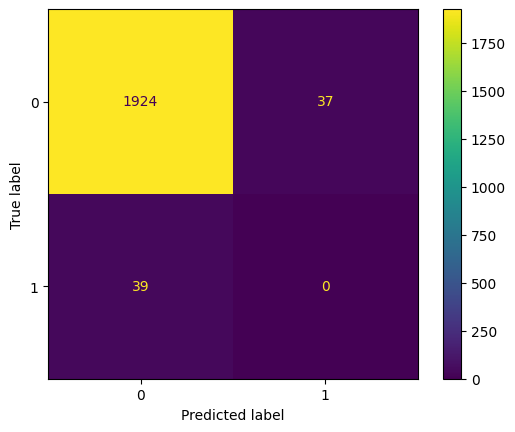

In [ ]:
with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_b(X_test).squeeze()
    predictions = torch.round(torch.sigmoid(test_logits))
    cm = confusion_matrix(y_test, predictions, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)